In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime

/Users/chelimin/miniconda2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/chelimin/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
macro = pd.read_csv('input/macro.csv')

In [3]:
train_df=pd.merge(macro, train)
train_df.shape

(30471, 391)

In [4]:
train_df.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,2011-08-20,109.31,14313.7,3.3,354.0,420.7,86.721,15.459,10.1,29.0048,...,9,4,0,13,22,1,0,52,4,5850000
1,2011-08-23,109.31,14313.7,3.3,354.0,420.7,86.721,15.459,10.1,28.9525,...,15,3,0,15,29,1,10,66,14,6000000
2,2011-08-27,109.31,14313.7,3.3,354.0,420.7,86.721,15.459,10.1,28.8082,...,10,3,0,11,27,0,4,67,10,5700000
3,2011-09-01,111.29,14313.7,3.3,353.2,434.4,86.721,15.386,10.1,28.9655,...,11,2,1,4,4,0,0,26,3,13100000
4,2011-09-05,111.29,14313.7,3.3,353.2,434.4,86.721,15.386,10.1,29.4625,...,319,108,17,135,236,2,91,195,14,16331452


In [5]:
test_df=pd.merge(macro, test)
test_df.shape

(7662, 390)

### Data preprocessing

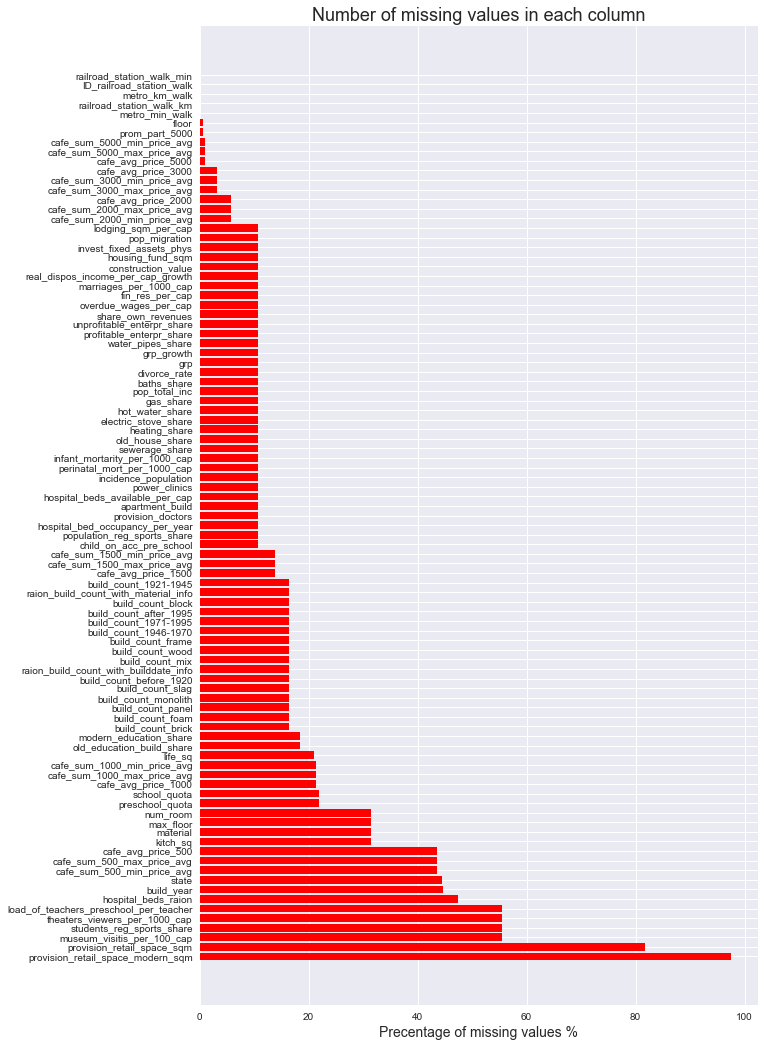

In [6]:
#missing values in train_df

missing = train_df.isnull().sum(0).reset_index()
missing.columns = ['column', 'count']
missing = missing.sort_values(by = 'count', ascending = False).loc[missing['count'] > 0]
missing['percentage'] = missing['count'] / float(train_df.shape[0]) * 100
ind = np.arange(missing.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, missing.percentage.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column.values, rotation='horizontal')
ax.set_xlabel("Precentage of missing values %", fontsize = 14)
ax.set_title("Number of missing values in each column", fontsize = 18)
plt.show()

In [7]:
#drop features with more than 30% missing values from train and test

delete_col = missing.loc[missing['percentage'] >= 30].column.values
train_set = train_df.drop(delete_col, axis=1)
test_set = test_df.drop(delete_col, axis=1)

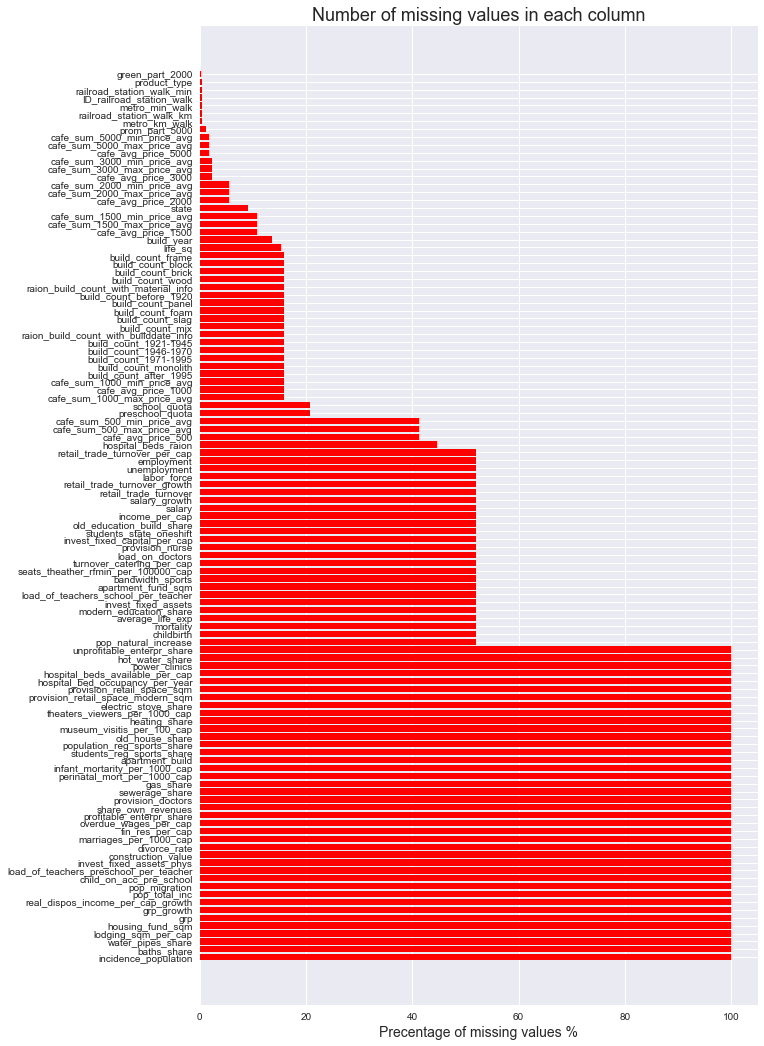

In [8]:
#missing values in test_df

missing = test_df.isnull().sum(0).reset_index()
missing.columns = ['column', 'count']
missing = missing.sort_values(by = 'count', ascending = False).loc[missing['count'] > 0]
missing['percentage'] = missing['count'] / float(test_df.shape[0]) * 100
ind = np.arange(missing.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, missing.percentage.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column.values, rotation='horizontal')
ax.set_xlabel("Precentage of missing values %", fontsize = 14)
ax.set_title("Number of missing values in each column", fontsize = 18)
plt.show()

In [9]:
#drop features with more than 30% missing values from train and test

delete_col = missing.loc[missing['percentage'] > 30].column.values
train_set = train_df.drop(delete_col, axis=1)
test_set = test_df.drop(delete_col, axis=1)

In [10]:
train_set.shape

(30471, 322)

In [11]:
test_set.shape

(7662, 321)

In [12]:
for f in train_set.columns:
    if train_set[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_set[f].values)) 
        train_set[f] = lbl.transform(list(train_set[f].values))
dtype_df = train_set.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,175
1,float64,147


In [13]:
#Imputing missing values in train_set

imputer = preprocessing.Imputer(missing_values=np.nan, strategy = 'median', axis =1)

train_data = pd.DataFrame(imputer.fit_transform(train_set))
train_data.columns = train_set.columns
train_data.index = train_set.index

In [ ]:
#Normalize train_data...can't normalize test_data? 

# train_data = pd.DataFrame(preprocessing.normalize(train_data, axis =1, copy=True, return_norm=False))
# train_data.columns = train_set.columns
# train_data.index = train_set.index

In [14]:
y_train = train_data["price_doc"]
x_train = train_data.drop(["id","timestamp", "price_doc"], axis=1)
x_test = test_set.drop(["id","timestamp"], axis=1)

In [15]:
for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True)    

### XGBoost

[0]	train-rmse:8.20542e+06	test-rmse:8.21364e+06
[50]	train-rmse:2.53255e+06	test-rmse:2.92248e+06
[100]	train-rmse:2.17379e+06	test-rmse:2.73279e+06
[150]	train-rmse:2.0374e+06	test-rmse:2.68087e+06
[200]	train-rmse:1.93912e+06	test-rmse:2.65625e+06
[250]	train-rmse:1.86682e+06	test-rmse:2.64283e+06
[300]	train-rmse:1.80432e+06	test-rmse:2.63855e+06
[350]	train-rmse:1.74464e+06	test-rmse:2.63185e+06
[400]	train-rmse:1.69167e+06	test-rmse:2.62829e+06
[450]	train-rmse:1.64273e+06	test-rmse:2.62444e+06
[500]	train-rmse:1.59833e+06	test-rmse:2.62228e+06
[550]	train-rmse:1.55935e+06	test-rmse:2.6214e+06


NameError: name 'metrics' is not defined

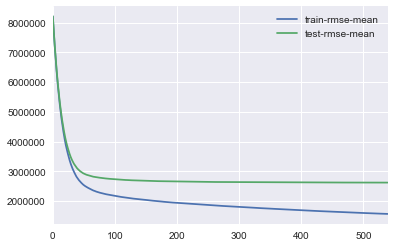

In [16]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)
y_pred = model.predict(dtest)

In [18]:
y_predict = model.predict(dtest)
output = pd.DataFrame({'id': test.id, 'price_doc': y_predict})
output.head()

,id,price_doc
0,30474,5667231.5
1,30475,8626848.0
2,30476,5893642.5
3,30477,6421949.0
4,30478,5566206.0


In [19]:
output.to_csv('sberbank1.csv', index=False)

### TensorFlow

In [24]:
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import metrics

# TensorFlow Regression using DNN
features = learn.infer_real_valued_columns_from_input(x_train)

# Optimizer algorithm
adam = tf.train.AdamOptimizer(learning_rate=0.001)

# Build a multi-layer DNN for regression
model_nn = learn.DNNRegressor(feature_columns=features, hidden_units=[400, 200, 100], 
                              optimizer=adam, activation_fn=tf.nn.relu,
                              )

# Fit and predict
model_nn.fit(x_train, y_train, steps=15000, batch_size=512)
y_pred = model_nn.predict(x_test)


print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x126920d10>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and b

NameError: name 'y_test' is not defined

In [25]:
y_pred = model.predict(dtest)
output = pd.DataFrame({'id': test.id, 'price_doc': y_pred})
output.head()

,id,price_doc
0,30474,5667231.5
1,30475,8626848.0
2,30476,5893642.5
3,30477,6421949.0
4,30478,5566206.0


In [26]:
output.to_csv('sberbank_tf.csv', index=False)